In [1]:
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 12.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 4.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 14.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[n

In [4]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt
import numpy as np
from time import time
import os
import shutil

2024-09-23 21:54:12.487290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 21:54:12.501896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 21:54:12.506541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 21:54:12.518482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 21:54:13.314219: W tensorflow/compiler/tf2

In [5]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1727124863.280770   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727124863.323182   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727124863.323440   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv")

#df.head()
df,  dropped_cols= drop_static_columns(df)
# convert time to seconds since midnight
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['time_in_seconds'] = (df['Timestamp'].dt.hour * 3600 + df['Timestamp'].dt.minute * 60 + df['Timestamp'].dt.second)              
df.set_index('time_in_seconds', inplace=True)
df.drop(columns=['Timestamp', 'time'], inplace=True)

# normalised data
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)
df_normalised.to_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv",index=False)



In [6]:
df = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_2015_12_23_for_tf.csv")

In [7]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
0,-1.608031,1.824135,-1.55021,0.585352,2.475287,-0.112313,0.578473,0.085272,0.579321,-1.699887,...,1.386669,0.072135,0.363321,-0.274278,-0.576233,-0.282796,-1.05009,-0.233109,-0.096308,-0.088802
1,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.581718,0.306260,0.579321,0.588275,...,1.386669,0.072135,-0.623212,-0.274278,0.735024,-0.328344,-1.05009,-0.233109,-0.096308,-0.088802
2,-1.608031,1.821131,-1.55021,0.585352,2.475287,-0.112313,0.589288,0.430235,0.579321,0.588275,...,1.386669,0.072135,-0.723537,-0.274278,0.735024,-0.442179,-1.05009,-0.246041,-0.096308,-0.088802
3,-1.608031,1.820797,-1.55021,0.585352,2.341305,-0.124024,0.597939,0.512685,0.579321,0.588275,...,1.386669,0.072135,-0.297175,0.905646,0.735024,-0.442179,-1.05009,-0.362587,-0.096308,-0.088802
4,-1.608031,1.818460,-1.55021,0.585352,2.341305,-0.124024,0.610196,0.565044,0.579321,0.588275,...,1.386669,0.072135,0.681068,0.905646,0.735024,-0.294165,-1.05009,-0.362587,-0.096308,-0.088802


In [8]:
component_map = list(df.columns)
len(component_map)

37

In [9]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [10]:
df_test = df
df_test.shape

(86400, 37)

In [11]:
#df_test.set_index('time_in_seconds', inplace=True)
data_array = df_test.to_numpy()




In [12]:
# shape of array
data_array.shape

(86400, 37)

In [13]:
# dataset in single slices of array so 1 second rows
#dataset.element_spec

In [14]:
# Window size in seconds
window_size = 20
# Define batch of windows to process in parallel before updating weights 
batch_size = 32


def windowed_dataset(data_array, window_size, batch_size):
    '''
    get full dataset as np array
    :param series: 
    :param window_size: 
    :param batch_size: 
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last row)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    
    # batch 
    dataset = dataset.batch(batch_size)
    
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    
    return dataset
    
    

In [15]:
split_time = int(data_array.shape[0] * 0.8)
train_dataset = data_array[:split_time]
val_dataset = data_array[split_time:]
train_dataset.shape
val_dataset.shape

(17280, 37)

In [16]:
train_dataset = windowed_dataset(train_dataset, window_size, batch_size)
val_dataset = windowed_dataset(val_dataset, window_size, batch_size)

I0000 00:00:1727124889.474614   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727124889.475071   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727124889.475415   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727124889.546016   27715 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [17]:
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (19, 37)
    print("Label shape: ", label.shape)        # Should be (37,)

Features shape:  (32, 19, 37)
Label shape:  (32, 1, 37)


2024-09-23 21:54:53.463815: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Count the number of windows
num_windows = train_dataset.reduce(0, lambda x, _: x + 1).numpy() * batch_size


print(f"Number of windows: {num_windows}")

Number of windows: 69120


# split data
train_size = int(0.8 * num_windows)
train_dataset = windowed_dataset.take(train_size)
val_dataset = windowed_dataset.skip(train_size)

# batch data
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [18]:
for feature, lable in train_dataset.take((1)):
    print(feature.numpy().shape)

(32, 19, 37)


2024-09-19 14:54:27.073582: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
(window_size - 1, data_array.shape[1])

(19, 37)

# Hyperparameter Optimisation



In [20]:
# Directory for model performance logs
LOG_DIR = os.path.join("my_tuner_logs")

In [69]:
BI_LOG_DIR = os.path.join("my_bi_tuner_logs")

In [82]:
def build_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
   
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with 50 units (neurons) and 
    model.add(LSTM(50))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.00005)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model #, epochs, steps_per_epoch



In [83]:
def build_bi_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(50)))
       
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.00005)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model #, epochs, steps_per_epoch



In [124]:
def build_model_tuner(hp):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an LSTM layer with tuner range 
    model.add(LSTM(units=lstm_units))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model #, epochs, steps_per_epoch



In [125]:
def build_bi_model_tuner(hp):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an bidirectional LSTM layer with tuner range 
    model.add(Bidirectional(LSTM(units=lstm_units)))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    
    return model #, epochs, steps_per_epoch



In [117]:
def build_best_model(tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with best number of units (neurons)
    model.add(LSTM(lstm_units))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model



In [99]:
def build_best_bi_model(bi_tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = bi_tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(lstm_units)))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model



In [51]:
LOG_DIR

'my_tuner_logs'

In [114]:
# Clear logs to run tuner from scratch
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)  # Deletes the directory and its contents


# keras tuner to find optimum model
tuner = RandomSearch(build_model_tuner,
                     objective = "val_loss",
                     max_trials = 5,
                     executions_per_trial = 1,
                     directory = LOG_DIR,
                     project_name = "lstm_all_data"
                     )

In [104]:
# Clear logs to run tuner from scratch
if os.path.exists(BI_LOG_DIR):
    shutil.rmtree(BI_LOG_DIR)  # Deletes the directory and its contents
    
# keras tuner to find optimum model
bi_tuner = RandomSearch(build_bi_model_tuner,
                     objective = "val_loss",
                     max_trials = 5,
                     executions_per_trial = 1,
                     directory = BI_LOG_DIR,
                     project_name = "lstm_all_data"
                     )

## Tuner Version

In [115]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the tuner
tuner.search(
    train_dataset,  # Pass your windowed and batched training dataset
    epochs=10,
    validation_data=val_dataset,  # Pass your windowed and batched validation dataset
    callbacks=[early_stop]
)

Trial 5 Complete [00h 00m 48s]
val_loss: 1.269281029701233

Best val_loss So Far: 0.16483548283576965
Total elapsed time: 00h 04m 09s


In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the tuner
bi_tuner.search(
    train_dataset,  # Pass your windowed and batched training dataset
    epochs=10,
    validation_data=val_dataset,  # Pass your windowed and batched validation dataset
    callbacks=[early_stop]
)

Trial 5 Complete [00h 01m 43s]
val_loss: 0.22782683372497559

Best val_loss So Far: 0.2219981700181961
Total elapsed time: 00h 11m 14s


In [53]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Best hyperparameters:
lstm_units: 80
dense_units: 64
learning_rate: 5.164419548491746e-05


5.164419548491746e-05

In [55]:
# Best model
best_simple_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/loz/MSc/MSc_Project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        37,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,349 (177.14 KB)

 Trainable params: 45,349 (177.14 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Rebuild the model and load weights from the best model
best_simple_model = build_best_model(tuner)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_history = best_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_simple_history = best_simple_model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

In [42]:
best_history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

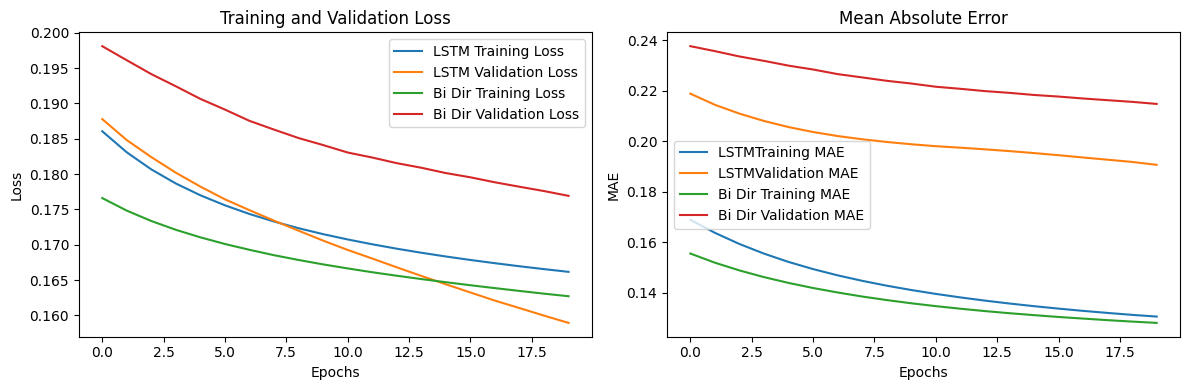

In [121]:
compare_models(best_history, best_bi_history, "LSTM", "Bi Dir")

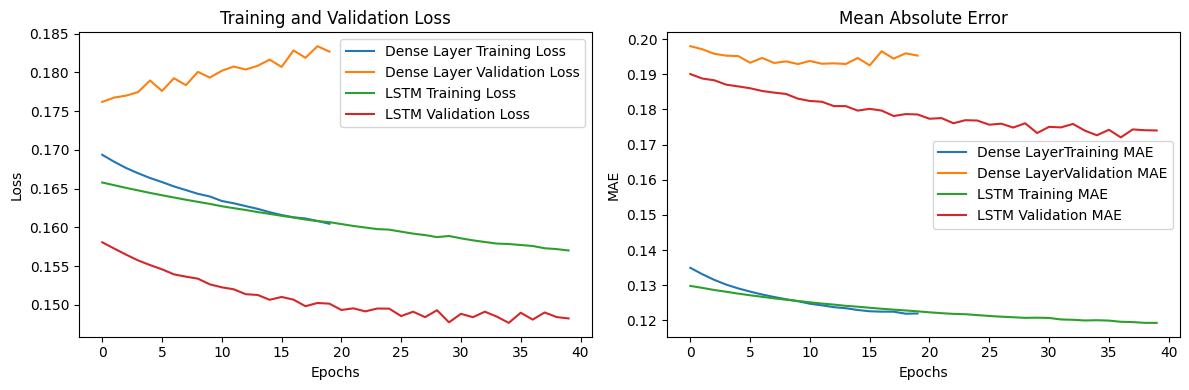

In [126]:
compare_models(best_simple_history, best_history, "Dense Layer", "LSTM")

In [118]:
# Rebuild the model and load weights from the best model no lstm
best_dense_model = build_best_model(tuner)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_dense_history = best_dense_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

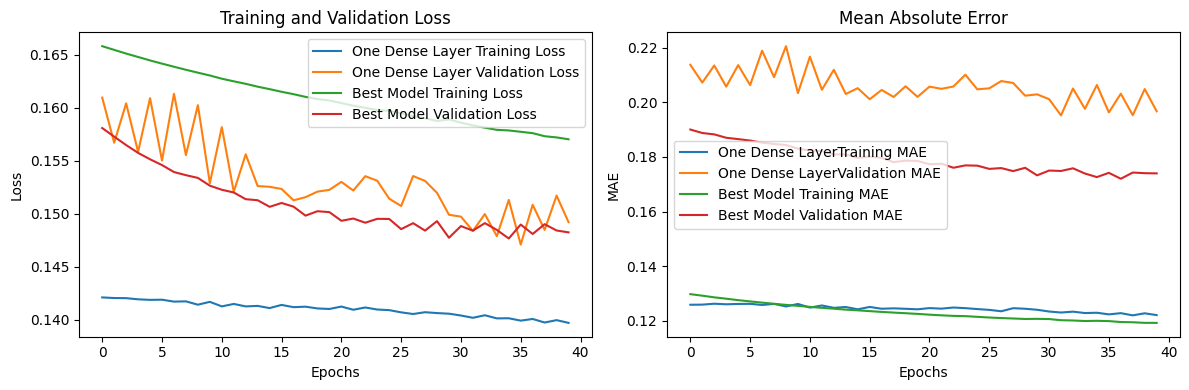

In [130]:
compare_models(best_dense_history, best_history, "One Dense Layer", "Best Model")

# Bi Directional

In [74]:
# Best hyperparameters
best_bi_hps = bi_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_bi_hps.values.items():
    print(f"{key}: {value}")

Best hyperparameters:
lstm_units: 96
dense_units: 64
learning_rate: 0.0005844956795537632


In [76]:
# Rebuild the model and load weights from the best model
best_bi_model = build_best_bi_model(tuner)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_bi_history = best_bi_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

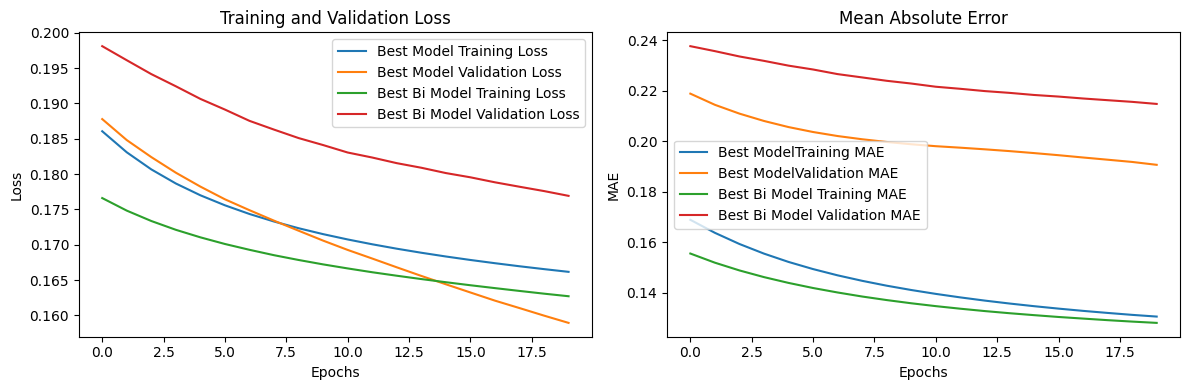

In [122]:
compare_models(best_history, best_bi_history, "Best Model", "Best Bi Model")

## Original Models

In [85]:
model = build_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         1,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,487 (76.12 KB)

 Trainable params: 19,487 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
bi_model = build_bi_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 37)             │         3,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,937 (152.10 KB)

 Trainable params: 38,937 (152.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)


In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
bi_history = bi_model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=bi_steps_per_epoch,
    validation_data=val_dataset
)



In [46]:
#history_dict['val_mae']

[0.30992981791496277,
 0.3008570373058319,
 0.28729987144470215,
 0.2620809078216553,
 0.2625470459461212,
 0.269218385219574,
 0.2402947098016739,
 0.24070829153060913,
 0.26532796025276184,
 0.2421676367521286,
 0.24359402060508728,
 0.2437315434217453,
 0.24171429872512817,
 0.261157363653183,
 0.252514123916626]

In [44]:
#history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

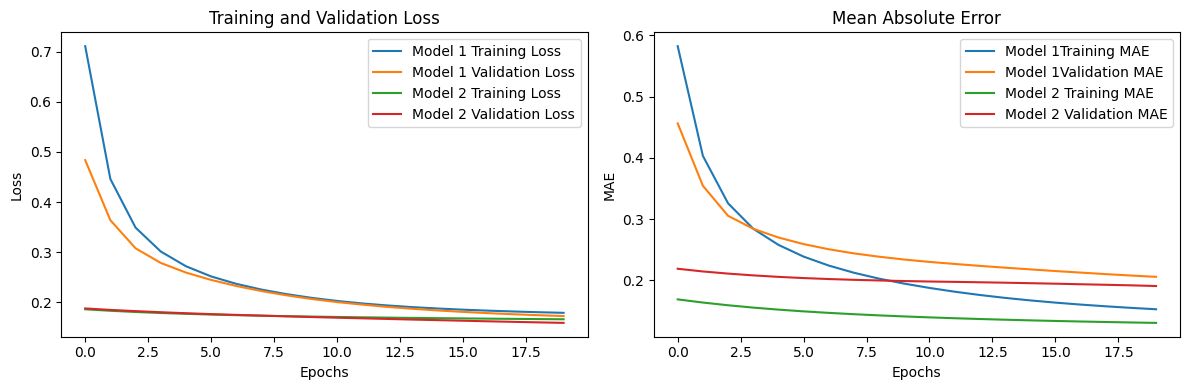

In [89]:
compare_models(history, best_history)

In [36]:
def compare_models(history_1, history_2, history_1_name="Model 1", history_2_name="Model 2"):  
    
    # Assuming `history` is the output from model.fit()
    
    history_1_dict = history_1.history
    history_2_dict = history_2.history
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_1_dict['loss'], label=f'{history_1_name} Training Loss')
    if 'val_loss' in history_1_dict:
        plt.plot(history_1_dict['val_loss'], label=f'{history_1_name} Validation Loss')
        
    plt.plot(history_2_dict['loss'], label=f'{history_2_name} Training Loss')
    if 'val_loss' in history_2_dict:
        plt.plot(history_2_dict['val_loss'], label=f'{history_2_name} Validation Loss')
        
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy (if available)
    plt.subplot(1, 2, 2)
    
    if 'mae' in history_1_dict:
        plt.plot(history_1_dict['mae'], label=f'{history_1_name}Training MAE')
    if 'val_mae' in history_1_dict:
        plt.plot(history_1_dict['val_mae'], label=f'{history_1_name}Validation MAE')
     
    if 'mae' in history_2_dict:
        plt.plot(history_2_dict['mae'], label=f'{history_2_name} Training MAE')
    if 'val_mae' in history_2_dict:
        plt.plot(history_2_dict['val_mae'], label=f'{history_2_name} Validation MAE')  
    
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()


In [16]:
model.save('swat_lstm_100s.keras')

In [131]:
# save best model from lstm tuner
model.save('best_model.keras')

# Open Saved Model

In [18]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
#swat_lstm = tf.keras.models.load_model('best_model.keras')
#model_window = 20
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
model_window = 100

In [19]:
# Reshape the input from data_array to add the batch dimension
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 37)

# Make predictions
predictions = swat_lstm.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
[[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]


2024-09-23 21:56:51.367526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


In [16]:
actual = data_array[model_window-1:model_window, :]

In [17]:
reshaped_input.shape

(1, 99, 37)

In [18]:
actual

array([[-1.60803075,  1.39821286, -1.55020996,  0.58535159,  2.14028964,
        -0.51839683,  0.71329708,  0.61367085,  0.57932135,  0.58827456,
        -0.92233481,  0.51362799,  0.46787354, -1.57205191, -0.04912496,
         0.48112757, -0.11892534, -0.12449482, -0.01128411,  0.46178413,
        -0.79145985,  0.90939238,  0.15634357, -1.11978876, -0.34043019,
         0.93175224,  1.00190234,  1.50947237, -0.12515386, -1.29212782,
        -0.27427769,  0.68043468, -0.55601419, -1.29954125, -0.49206393,
        -0.09630808, -0.08880187]])

In [19]:
difference = actual - predictions

# Print results
print("Predictions:\n", predictions)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[-1.6873796   1.0725484  -1.6856784   0.5893998   1.2647659  -0.6372988
   0.81754637  0.5705057   0.5782185   0.5621133  -1.0134225   0.46552265
   0.3625184  -1.7182541  -0.08421671  0.45475912 -0.03200638 -0.09545343
  -0.00451893  0.34572366 -0.7700037   0.22403386  0.01046308 -1.1046661
  -0.38610268  0.06470605  0.83374614  1.4891282   0.08482892  0.150914
  -0.49433717  0.16404936 -0.7478318  -1.3892689  -0.76368266 -0.03951834
  -0.00188439]]
Actual Values:
 [[-1.60803075  1.39821286 -1.55020996  0.58535159  2.14028964 -0.51839683
   0.71329708  0.61367085  0.57932135  0.58827456 -0.92233481  0.51362799
   0.46787354 -1.57205191 -0.04912496  0.48112757 -0.11892534 -0.12449482
  -0.01128411  0.46178413 -0.79145985  0.90939238  0.15634357 -1.11978876
  -0.34043019  0.93175224  1.00190234  1.50947237 -0.12515386 -1.29212782
  -0.27427769  0.68043468 -0.55601419 -1.29954125 -0.49206393 -0.09630808
  -0.08880187]]
Difference:
 [[ 7.93488498e-02  3.25664471e-01  1.3546

In [21]:
type(difference_list)

list

# Predict Whole Dataset

In [22]:
split_time = int(data_array.shape[0] * 0.8)

val_dataset = data_array[split_time:]
##predict first 100 
predict_dataset = val_dataset[:1200]

In [23]:
#predict_dataset

In [24]:
#len(val_dataset)

In [25]:
#input_window.shape

In [26]:
# Define a list to hold all predictions
all_predictions = []

# Loop through the dataset and predict step by step
for i in range(len(predict_dataset) - model_window + 1):
    # Extract the window of input data for prediction
    input_window = predict_dataset[i:i+model_window-1, :].reshape(1, model_window-1, data_array.shape[1])
    
    # Predict the next timestep
    predicted = swat_lstm.predict(input_window)
    
    # Save the prediction
    all_predictions.append(predicted[0])

# Convert predictions list to numpy array
all_predictions = np.array(all_predictions)

# Get the actual data for comparison (the next step in each window)
actual_data = predict_dataset[model_window-1:, :]  # All rows starting from model_window-1


# Optionally, you can calculate some error metrics
mae = np.mean(np.abs(all_predictions - actual_data))
print(f"Mean Absolute Error: {mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [27]:
type(all_predictions)

numpy.ndarray

In [28]:
all_predictions.shape

(1101, 37)

In [29]:
df_predictions = pd.DataFrame(all_predictions, columns=component_map)
df_predictions.info

<bound method DataFrame.info of         FIT101    LIT101     MV101      P101    AIT201    AIT202    AIT203  \
0     0.592011  0.679188  0.553870 -1.730768 -1.325567 -0.168051 -1.224900   
1     0.596343  0.676751  0.555896 -1.738006 -1.321445 -0.157921 -1.226078   
2     0.595480  0.732125  0.553414 -1.738605 -1.344326 -0.147657 -1.210019   
3     0.598024  0.699389  0.554191 -1.749342 -1.331017 -0.138389 -1.203547   
4     0.594715  0.724607  0.552670 -1.750624 -1.326610 -0.131548 -1.206742   
...        ...       ...       ...       ...       ...       ...       ...   
1096 -1.669414  0.145402 -1.726159  0.510960 -1.162762 -0.683895 -0.830269   
1097 -1.665702  0.144357 -1.720063  0.510878 -1.158147 -0.687335 -0.835594   
1098 -1.673679  0.143520 -1.729874  0.503644 -1.161272 -0.672816 -0.833197   
1099 -1.670469  0.136658 -1.726400  0.502552 -1.158791 -0.671797 -0.830702   
1100 -1.674078  0.162939 -1.724989  0.485596 -1.160694 -0.653475 -0.834396   

        FIT201     MV201      P

In [30]:
predict_dataset = predict_dataset[window_size-1:]

NameError: name 'window_size' is not defined

In [31]:
df_actual = pd.DataFrame(predict_dataset, columns=component_map)
df_actual.info

<bound method DataFrame.info of         FIT101    LIT101     MV101      P101    AIT201    AIT202    AIT203  \
0     0.529594  0.301697  0.620586 -1.708375 -1.236362 -0.124024 -1.118375   
1     0.524261  0.309041  0.620586 -1.708375 -1.236362 -0.124024 -1.118375   
2     0.521736  0.315049  0.620586 -1.708375 -1.236362 -0.124024 -1.118375   
3     0.521736  0.316718  0.620586 -1.708375 -1.236362 -0.124024 -1.118375   
4     0.570005  0.326063  0.620586 -1.708375 -1.236362 -0.124024 -1.118375   
...        ...       ...       ...       ...       ...       ...       ...   
1195 -1.608031  0.474936 -1.550210  0.585352 -1.316776 -0.547685 -0.867832   
1196 -1.608031  0.470264 -1.550210  0.585352 -1.316776 -0.547685 -0.868913   
1197 -1.608031  0.470264 -1.550210  0.585352 -1.316776 -0.547685 -0.868913   
1198 -1.608031  0.464922 -1.550210  0.585352 -1.316776 -0.547685 -0.869273   
1199 -1.608031  0.461585 -1.550210  0.585352 -1.316776 -0.547685 -0.872518   

        FIT201     MV201      P

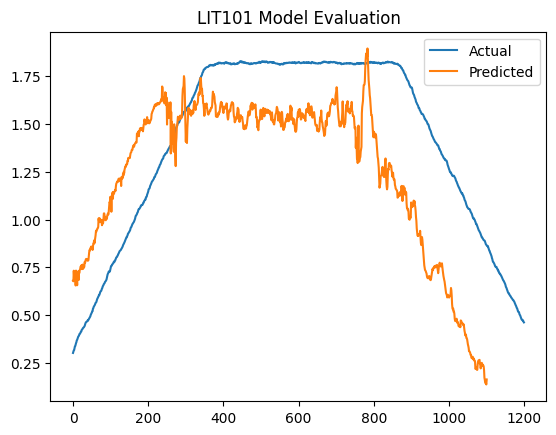

Mean Absolute Error: 0.3781835333599164


In [32]:
plt.plot(df_actual['LIT101'], label='Actual')
plt.plot(df_predictions['LIT101'], label='Predicted')

plt.title('LIT101 Model Evaluation')
plt.legend()
plt.show()
mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
print(f"Mean Absolute Error: {mae}")

In [33]:
# Assuming `history` is the output from model.fit()

history_1_dict = best_history.history


# Plot training & validation loss
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)

if 'mae' in history_1_dict:
    plt.plot(history_1_dict['mae'], label='Train MAE')
if 'val_mae' in history_1_dict:
    plt.plot(history_1_dict['val_mae'], label='Val MAE')
    
if 'loss' in history_1_dict:
    plt.plot(history_1_dict['loss'], label='Train Loss')
if 'val_loss' in history_1_dict:
    plt.plot(history_1_dict['val_loss'], label='Val Loss')
        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

# Plot accuracy (if available)
plt.subplot(1, 2, 2)

plt.plot(df_actual['LIT101'], label='Actual')
plt.plot(df_predictions['LIT101'], label='Predicted')

mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
plt.legend([f'LIT101 Actual', f'Predicted (MAE: {mae:.4f})'])


plt.xlabel('Seconds')
plt.ylabel('Scaled Value')

# Show the plots
#plt.tight_layout()

# Save the plot to a file (e.g., "plot.png")
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/LSTM_Eval.jpeg')
plt.show()

NameError: name 'best_history' is not defined

# Train Agent

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')